In [1]:
import pandas as pd
import numpy as np
from string import punctuation
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from rapidfuzz import fuzz, process

In [2]:
subway_df = pd.read_csv('ttc-subway-delay-data-2024.csv')
stations = pd.read_csv('subway_station_gps.csv')

In [3]:
subway_df.columns = [s.strip().replace(' ','_') for s in subway_df.columns]
subway_df.rename(columns={'Bound': 'Direction'}, inplace=True)
subway_df.rename(columns={'Line': 'Route'}, inplace=True)
subway_df.rename(columns={'Station': 'Location'}, inplace=True)
subway_df['TransportType'] = 'Subway'
subway_df['Incident'] = 'Subway'
stations['wheelchair_boarding'] = 1
subway_df = subway_df.drop(columns = ['Min_Gap'])
subway_df = subway_df.drop(columns = ['Code'])

In [4]:
subway_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19702 entries, 0 to 19701
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           19702 non-null  object
 1   Time           19702 non-null  object
 2   Day            19702 non-null  object
 3   Location       19702 non-null  object
 4   Min_Delay      19702 non-null  int64 
 5   Direction      12736 non-null  object
 6   Route          19674 non-null  object
 7   Vehicle        19702 non-null  int64 
 8   TransportType  19702 non-null  object
 9   Incident       19702 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.5+ MB


In [5]:
Line_To_Include = ["YU","BD","SRT","SHP"]

In [6]:
# Remove rows 
subway_df = subway_df[subway_df["Route"].isin(Line_To_Include)]

In [7]:
subway_df.nunique()

Date              274
Time             1412
Day                 7
Location          368
Min_Delay          95
Direction           5
Route               4
Vehicle           722
TransportType       1
Incident            1
dtype: int64

## 1.1 Missing Values

In [8]:
subway_df.isnull().sum()

Date                0
Time                0
Day                 0
Location            0
Min_Delay           0
Direction        6652
Route               0
Vehicle             0
TransportType       0
Incident            0
dtype: int64

In [9]:
## 1.2 Date and Time Formatting 

In [10]:
# Function to split the date
def split_date(date_str):
    # Convert the date string to a datetime object
    # Check if date is in 1-Jan-24 format
    if re.match(r"\d{1,2}-[A-Za-z]{3,4}-\d{2}", date_str):
        date_obj = pd.to_datetime(date_str, format='%d-%b-%y')
    # Check if date is in 2024-01-01 format
    elif re.match(r"\d{4}-\d{2}-\d{2}", date_str):
        date_obj = pd.to_datetime(date_str, format='%Y-%m-%d')
    else:
        raise ValueError(f"Unknown date format: {date_str}")

    # Extract day, month, and year
    day = date_obj.day
    month = date_obj.month
    year = date_obj.year

    # Standardize to DD-MM-YYYY
    return datetime(year, month, day).strftime("%d-%m-%Y")

In [11]:
subway_df.loc[:, 'Date'] = subway_df.loc[:,'Date'].apply(split_date)

## 1.3 Delays

In [12]:
# on time is 0 mins delays
# short delay is 1 to 15 mins.
# medium delay is 15 to 30 mins.
# long delay is more than 30 mins.
def delay_type(col):
    if col == 0 :
        return 'on-time'
    elif col >= 1 and col <= 15:
        return 'short'
    elif col > 15 and col <= 30:
        return 'medium'
    elif col > 30:
        return 'long'

# apply delay_type function
subway_df.loc[:, 'delay_type'] = subway_df.loc[:,'Min_Delay'].apply(delay_type)

## 1.4 Filtering out Irrelevent Directions

In [13]:
# function to simplify direction in to N,S,E,W,B and NaN.
def direction_filter(direction):
    # convert all lowercase characters to uppercase, replace punctuations with empty space and remove leading and the trailing spaces.
    direction = str(direction).upper().replace(rf'[{punctuation}]', '').strip()
    if 'N' in direction:
        return 'N'
    elif 'S' in direction:
        return 'S'
    elif 'E' in direction:
        return 'E'
    elif 'W' in direction:
        return 'W'
    elif 'B' in direction:
        return 'B'
    else:
        'NaN'

subway_df.loc[:,'Direction'] = subway_df.loc[:,'Direction'].apply(direction_filter)

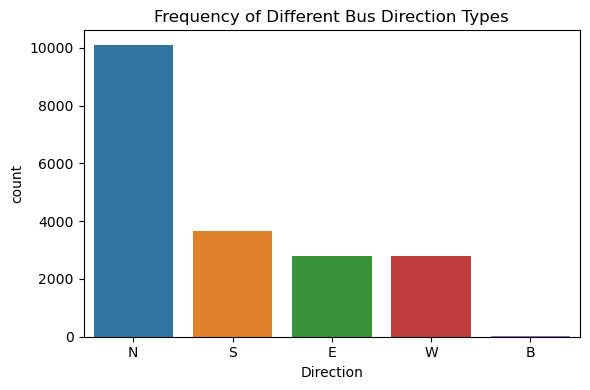

In [14]:
datasets = [subway_df]
titles = ['Bus Direction Types', 'Subway Direction Types', 'Streetcar Direction Types']
Direction_order = ['N', 'S', 'E', 'W', 'B']

for i, df in enumerate(datasets):
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Direction', data=df, order=Direction_order)
    plt.title(f'Frequency of Different {titles[i]}')
    plt.tight_layout()
    plt.show()

In [15]:
subway_df.isnull().sum()

Date             0
Time             0
Day              0
Location         0
Min_Delay        0
Direction        0
Route            0
Vehicle          0
TransportType    0
Incident         0
delay_type       0
dtype: int64

### Normalizing text in both datasets

In [16]:
# Standardize the case for matching
subway_df.loc[:, 'Station_lower'] = subway_df.loc[:, 'Location'].str.lower()
stations.loc[:, 'Station_name_lower'] = stations.loc[:, 'Station_name'].str.lower()

In [17]:
#from rapidfuzz import fuzz, process

# Function to normalize text (expand abbreviations and remove unnecessary words)
def normalize_text(text):
    text = text.lower()
    text = text.replace(' station ', ' ')
    text = text.replace(' at ', ' ')
    text = text.replace(' and ', ' ')
    text = text.replace(' - ', ' ')
    text = text.replace(' c ', ' ')
    text = text.replace(' bd ', ' ')
    return text.strip()

# Normalize the relevant columns
subway_df.loc[:, 'Normalized_Station'] = subway_df.loc[:, 'Station_lower'].apply(normalize_text)
stations.loc[:, 'Normalized_Station'] = stations.loc[:, 'Station_name_lower'].apply(normalize_text)

### Using fuzzy matching

In [18]:
# Perform fuzzy matching for unmatched records
def fuzzy_match(location, stop_names, threshold=80):
    match = process.extractOne(location, stop_names, scorer=fuzz.token_set_ratio)
    if match and match[1] >= threshold:
        return match[0]  # Return the best match if similarity exceeds the threshold
    return None

In [19]:
# Create a list of normalized stations names for matching
normalized_stations = stations['Normalized_Station'].tolist()

# Apply fuzzy matching to Clean_bus.csv
subway_df['Fuzzy_stations'] = subway_df['Normalized_Station'].apply(
    lambda x: fuzzy_match(x, normalized_stations)
)

# Merge the datasets while retaining all records from bus_df and matched stop details
subway_columns = ['Date', 'TransportType', 'Route', 'Time', 'Day', 'Location', 'Incident', 'Min_Delay', 'Direction', 'Vehicle', 'delay_type', 'Fuzzy_stations']
location_columns = ['Latitude', 'Longtitude', 'wheelchair_boarding']

final_merged_df = pd.merge(
    subway_df[subway_columns],
    stations[location_columns + ['Normalized_Station']],
    left_on='Fuzzy_stations',
    right_on='Normalized_Station',
    how='left'
)

### File merging of subway_station_gps.csv

In [20]:
subway_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19380 entries, 0 to 19701
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Date                19380 non-null  object
 1   Time                19380 non-null  object
 2   Day                 19380 non-null  object
 3   Location            19380 non-null  object
 4   Min_Delay           19380 non-null  int64 
 5   Direction           19380 non-null  object
 6   Route               19380 non-null  object
 7   Vehicle             19380 non-null  int64 
 8   TransportType       19380 non-null  object
 9   Incident            19380 non-null  object
 10  delay_type          19380 non-null  object
 11  Station_lower       19380 non-null  object
 12  Normalized_Station  19380 non-null  object
 13  Fuzzy_stations      17057 non-null  object
dtypes: int64(2), object(12)
memory usage: 2.2+ MB


In [21]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Line_name            75 non-null     object 
 1   Station_name         75 non-null     object 
 2   Latitude             75 non-null     float64
 3   Longtitude           75 non-null     float64
 4   wheelchair_boarding  75 non-null     int64  
 5   Station_name_lower   75 non-null     object 
 6   Normalized_Station   75 non-null     object 
dtypes: float64(2), int64(1), object(4)
memory usage: 4.2+ KB


In [22]:
# Drop 'Normalized_Station' & 'Fuzzy_stations' since it's not required in the final output
final_merged_df.drop(columns=['Fuzzy_stations', 'Normalized_Station'], inplace=True)

In [23]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19380 entries, 0 to 19379
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 19380 non-null  object 
 1   TransportType        19380 non-null  object 
 2   Route                19380 non-null  object 
 3   Time                 19380 non-null  object 
 4   Day                  19380 non-null  object 
 5   Location             19380 non-null  object 
 6   Incident             19380 non-null  object 
 7   Min_Delay            19380 non-null  int64  
 8   Direction            19380 non-null  object 
 9   Vehicle              19380 non-null  int64  
 10  delay_type           19380 non-null  object 
 11  Latitude             17057 non-null  float64
 12  Longtitude           17057 non-null  float64
 13  wheelchair_boarding  17057 non-null  float64
dtypes: float64(3), int64(2), object(9)
memory usage: 2.1+ MB


In [24]:
# Filter out unmatched records
Merged_subway = final_merged_df[~final_merged_df['Latitude'].isna()]

# Save the cleaned dataset
Merged_subway.to_csv('C:\\Users\\Jugal Patel\\Desktop\\Capstone project\\Data_cleaning\\Merged_subway.csv', index=False)

print(f"Merged_subway dataset saved with {Merged_subway.shape[0]} records.")

Merged_subway dataset saved with 17057 records.


In [25]:
final_merged_df.head()

,Date,TransportType,Route,Time,Day,Location,Incident,Min_Delay,Direction,Vehicle,delay_type,Latitude,Longtitude,wheelchair_boarding
0,01-01-2024,Subway,YU,02:00,Monday,SHEPPARD STATION,Subway,0,N,5491,on-time,NaN,NaN,NaN
1,01-01-2024,Subway,YU,02:00,Monday,DUNDAS STATION,Subway,0,N,0,on-time,43.656137,-79.380730,1.0
2,01-01-2024,Subway,YU,02:08,Monday,DUNDAS STATION,Subway,4,N,6051,short,43.656137,-79.380730,1.0
3,01-01-2024,Subway,BD,02:13,Monday,KENNEDY BD STATION,Subway,10,E,5284,short,43.732118,-79.265698,1.0
4,01-01-2024,Subway,YU,02:22,Monday,BLOOR STATION,Subway,4,N,5986,short,NaN,NaN,NaN
